In [1]:
import datarobot as dr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

In [2]:
dr.Client(config_path='drconfig.yaml')

Data preparation 
-------------------

In [3]:
wine_data = pd.read_csv('wine_data.csv', sep=';')

Making target again

In [4]:
wine_data['wine_is_good'] = wine_data['quality'].apply(lambda x: 'good' if x>=7 else 'bad')

Add noise for reference

In [5]:
np.random.seed(42)
wine_data['X1'] = np.random.normal(size=len(wine_data))
wine_data['X2'] = np.random.normal(size=len(wine_data))
wine_data['X3'] = np.random.normal(size=len(wine_data))
wine_data['X4'] = np.random.normal(size=len(wine_data))
wine_data['X5'] = np.random.normal(size=len(wine_data))

In [6]:
project = dr.Project.create(wine_data, "Wine Quality - Feature Impact / Partial Dependence")

Creating specifying custom partition

In [7]:
my_partition = dr.StratifiedTVH(validation_pct = 30, holdout_pct = 0)

Using TVH partitioning 

In [8]:
project.set_target(target = "wine_is_good", mode = dr.AUTOPILOT_MODE.MANUAL, positive_class = "good",
          partitioning_method = my_partition)

Project(Wine Quality - Feature Impact / Partial Dependence)

In [9]:
project.set_worker_count(-1)


Project(Wine Quality - Feature Impact / Partial Dependence)

Choosing some blueprints from repository

In [10]:
bps = project.get_blueprints()

In [11]:
selected_bps = [[b for b in bps if "Random" in b.model_type][0],
                [b for b in bps if "Neural" in b.model_type][0],
                [b for b in bps if "Logistic" in b.model_type][0],
                [b for b in bps if "Dropout" in b.model_type][0]]

Run models

In [12]:
model_job_ids = [project.train(b) for b in selected_bps]

In [13]:
[dr.Job.get(project.id, m).wait_for_completion() for m in model_job_ids]

[None, None, None, None]

Collect models

In [14]:
my_models = project.get_models()

In [15]:
my_models

[Model('RandomForest Classifier (Gini)'),
 Model('Dropout Additive Regression Trees Classifier  (15 leaves)'),
 Model('Regularized Logistic Regression (L2)'),
 Model('TensorFlow Neural Network Classifier')]

In [16]:
# Inspect feature importance across models -------------------------------

# Function to plot feature impacts (either normalized or unnormalized)
# Inputs are the project object and list of models to use
# Returns the plot and selected features based on cutoff
# Cutoff is simply which features to choose based on median of the feature impact scores
# e.g. a cutoff of 0.05 means eliminate any feature with a normalized median value less than 0.05
# Output is a graph visualizing the distribution of feature impact scores
# Normalized turned on by default

In [17]:
def plot_feature_impacts(project, models, cutoff=0.05, normalized=True):
    from statsmodels.distributions.empirical_distribution import ECDF
    if cutoff > 1:
        raise ValueError("Cutoff should be smaller than 1.")
    fi_jobs = []
    for m in models:
        try:
            m.get_feature_impact()
        except:
            fi_jobs.append(m.request_feature_impact())
    [j.wait_for_completion() for j in fi_jobs]
    # Collecting impacts
    print("Collecting Feature Impacts ...\n")
    impacts = pd.concat([pd.DataFrame.from_records(m.get_feature_impact()) for m in models])
    impacts = impacts.set_index('featureName')[['impactUnnormalized']]
    impacts['norm_value'] = impacts['impactUnnormalized']/np.max(impacts['impactUnnormalized'])
    
    # Calculating average feature impact score
    feature_impact_medians = impacts.groupby('featureName').median().rename(
                                columns={
                                    'impactUnnormalized':'unnorm_median_value',
                                    'norm_value':'norm_median_value'
                                })
    selected_features = feature_impact_medians[feature_impact_medians.norm_median_value>cutoff].index.values.tolist()
    if normalized:
        sns.set_style("darkgrid")
        plt.figure(figsize=(15,10))
        order=feature_impact_medians.norm_median_value.sort_values(ascending=False).index.values
        ax = sns.boxplot(y='featureName', x='norm_value', data=impacts.reset_index(), 
                         orient='h', order=order, color='w')
        ax.axvline(cutoff, c='r')
        ax.grid(axis='y')
    else:
        norm_ecdf = ECDF(feature_impact_medians.norm_median_value)
        norm_quant = norm_ecdf(cutoff)
        unnorm_cutoff = np.quantile(feature_impact_medians.unnorm_median_value, norm_quant)
        sns.set_style("darkgrid")
        plt.figure(figsize=(15,10))
        order=feature_impact_medians.unnorm_median_value.sort_values(ascending=False).index.values
        ax = sns.boxplot(y='featureName', x='impactUnnormalized', data=impacts.reset_index(), 
                         orient='h', order=order, color='w')
        ax.axvline(unnorm_cutoff, c='r')
        ax.grid(axis='y')
  
    return {'plot': ax, 'selected_features': selected_features}
  

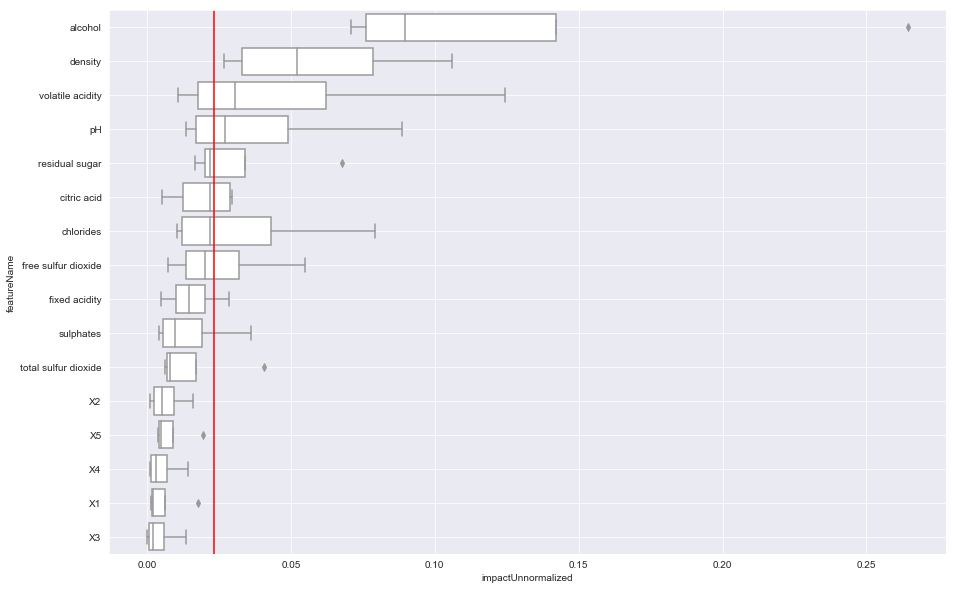

In [18]:
unnorm_plot = plot_feature_impacts(project, my_models, cutoff=0.1, normalized=False)

In [19]:
unnorm_plot['selected_features']

['alcohol', 'density', 'pH', 'volatile acidity']

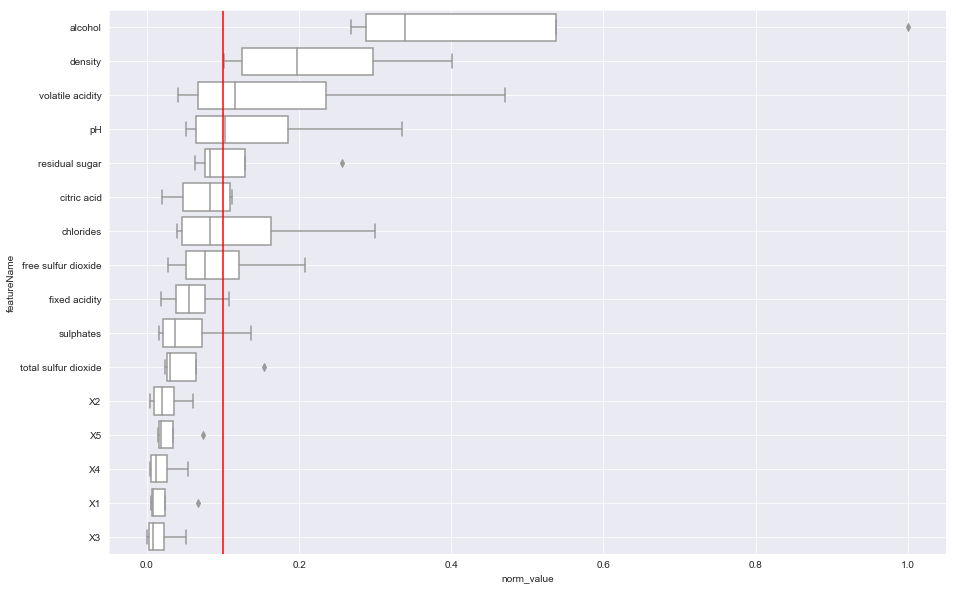

In [20]:
norm_plot = plot_feature_impacts(project, my_models, cutoff=0.1, normalized=True)

In [21]:
norm_plot['selected_features']

['alcohol', 'density', 'pH', 'volatile acidity']

Make new feature list 
---
Creating new feature list

In [22]:
featurelist_job = project.create_featurelist("Selected Features", norm_plot['selected_features'])

Retrain on best model

In [23]:
best_model = my_models[0]
best_model_reduced_id = best_model.train(featurelist_id = featurelist_job.id)
best_model_reduced = dr.Job.get(project.id, best_model_reduced_id).get_result_when_complete()
best_model_reduced

Model('RandomForest Classifier (Gini)')

Inspect leaderboard

In [24]:
pd.DataFrame.from_records([{'blueprintId': m.blueprint_id, 
                            'modelType':m.model_type, 
                            'featurelistName':m.featurelist_name,
                            'samplePct':m.sample_pct, 
                            'validationScore':m.metrics['LogLoss']['validation']
                           } for m in project.get_models()])

,blueprintId,featurelistName,modelType,samplePct,validationScore
0,de20704d755c3770b96dcad4aec57e52,Informative Features - Leakage Removed,RandomForest Classifier (Gini),69.9878,0.34513
1,de20704d755c3770b96dcad4aec57e52,Selected Features,RandomForest Classifier (Gini),69.9878,0.36208
2,d1755a701b9375b2dfa27e1cc5458f8a,Informative Features - Leakage Removed,Dropout Additive Regression Trees Classifier ...,69.9878,0.38119
3,2997bc57e8eeef97d3541d3d1d254cc5,Informative Features - Leakage Removed,Regularized Logistic Regression (L2),69.9878,0.41308
4,c9ece8ec9fcca29b7113f829d681ac49,Informative Features - Leakage Removed,TensorFlow Neural Network Classifier,69.9878,0.41498


Partial Dependence
---

Downloading training data predictions from DataRobot to grab validation fold rowID

In [26]:
validation_fold_id = best_model_reduced.request_training_predictions(dr.enums.DATA_SUBSET.VALIDATION_AND_HOLDOUT)

In [27]:
validation_fold = validation_fold_id.get_result_when_complete().get_all_as_dataframe()

In [28]:
validation = wine_data.iloc[validation_fold['row_id']]

In [29]:
# Function for generating feature effects from DataRobot manually
# Inputs are project object, model, desired dataset, and feature of interest.
# Returns the plot and plot data
# Sampling done by default for n > 1000 for speed purposes but can be turned off.
# size_of_grid is the number of feature values to use. Default is 25.
# grid is automatically created (quantiles for numerics, random sampling for categoricals). 
# size_of_grid can also take a vector of values for custom grids.
# Can plot ICE curves but turned off by default. Best to leave off for larger samples.
# Can also plot +/- 1 standard deviation around the average prediction.
# Can only be used for categoricals and numerics in the requested dataset (no DR derived features).
# Computing partial dependence for alcohol

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
def partial_dependence(project, model, data, feature, size_of_grid=25, 
                              sample_size=1000, ice_plot=False, std_dev_plot=False):
    np.random.seed(42)
    data = data.copy()
    if project.target_type == "Multiclass":
        raise ValueError("Feature Effects is not support for Multiclass yet.")
        
    if feature not in data.columns:
        raise ValueError("Specified feature is not found in dataset.")
        
    if sample_size:
        # Random sample if regression or if target is not included in dataset
        if (project.target_type == "Regression") | (project.target not in data.columns):
          # Random sample
          data = data.sample(n=min(len(data), sample_size), replace=False)
        else:
          # Stratified random sample
            max_sample_size = min(len(data)-2, sample_size)
            sampler = StratifiedShuffleSplit(n_splits=1, train_size=max_sample_size, test_size=len(data) - max_sample_size)
            idx, _ = list(sampler.split(np.zeros_like(data[project.target]), y=data[project.target]))[0]  
            data = data.iloc[idx]

    if np.issubdtype(data[feature].dtype, np.number):
        feature_type = "numeric"
    else:
        feature_type = "categorical"

    cats = data[feature].unique()

    if len(cats) > size_of_grid:
        if feature_type == "numeric":
            sampled_values = np.quantile(data[feature], q=np.linspace(start=0.05, stop=0.95, num=size_of_grid))
        else:
            sampled_values = np.random.choice(cats, size=size_of_grid, replace=False)
    else:
        sampled_values = cats
        
    data['rowID'] = range(len(data))
    df = []
    for x in sampled_values:
        data_temp = data.copy()
        data_temp[feature] = x
        df.append(data_temp)
    augmented_dataset = pd.concat(df)
    print(f"uploading augmented dataset with {len(augmented_dataset)} rows.")
    augmented_dataset_id = project.upload_dataset(augmented_dataset)
    
    print("Requesting predictions on augmented dataset")
    pred_job_id = model.request_predictions(augmented_dataset_id.id)
    predictions = pred_job_id.get_result_when_complete()
    if project.target_type == "Regression":
        augmented_dataset['predictions'] = predictions['prediction'].values
    else:
        augmented_dataset['predictions'] = predictions['positive_probability'].values
    print('Preparing plots')
    ice_plot_data = augmented_dataset[[feature, "rowID", "predictions"]]
    
    pd_plot_data = ice_plot_data.groupby(feature).apply(lambda df: pd.Series({'mean_pred': df['predictions'].mean(), 
                                                                          'sd': df['predictions'].std(), }))
    pd_plot_data['mean_minus_sd'] = pd_plot_data['mean_pred'] - pd_plot_data['sd']
    pd_plot_data['mean_plus_sd'] = pd_plot_data['mean_pred'] + pd_plot_data['sd']
    fig = plt.figure(figsize=(10,7))
    if ice_plot:
        if feature_type == "numeric":
            g = sns.lineplot(x=feature, y='predictions', data=ice_plot_data, units='rowID', estimator=None, linewidth=0.3, alpha=0.2, color='black') 
        else:
            g = sns.stripplot(x=feature, y='predictions', data=ice_plot_data, color='black',size=2, jitter=1, alpha=0.3,order=pd_plot_data.sort_values(by='mean_pred').index, zorder=1)    
    if feature_type == "numeric":
        g = sns.lineplot(x=feature, y='mean_pred', data=pd_plot_data.reset_index(), linewidth=6, color='black')
        g = sns.lineplot(x=feature, y='mean_pred', data=pd_plot_data.reset_index(), linewidth=5, color = 'gold')
    else:
        g = sns.pointplot(x=feature, y='mean_pred', data=pd_plot_data.reset_index(), color='black', join=False, order=pd_plot_data.sort_values(by='mean_pred').index, scale=1.)
        g = sns.pointplot(x=feature, y='mean_pred', data=pd_plot_data.reset_index(), color = 'gold', join=False, order=pd_plot_data.sort_values(by='mean_pred').index,scale=0.8)
        g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right')
    if std_dev_plot:
        if feature_type == "numeric":
            g = sns.lineplot(x=feature, y='mean_plus_sd', data=pd_plot_data.reset_index(), linewidth=1.5, color='darkorchid')
            g = sns.lineplot(x=feature, y='mean_minus_sd', data=pd_plot_data.reset_index(), linewidth=1.5, color='darkorchid')
        else:
            g = sns.pointplot(x=feature, y='mean_plus_sd', data=pd_plot_data.reset_index(), color='darkorchid', join=False, order=pd_plot_data.sort_values(by='mean_pred').index, scale=1.)
            g = sns.pointplot(x=feature, y='mean_minus_sd', data=pd_plot_data.reset_index(), color='darkorchid', join=False, order=pd_plot_data.sort_values(by='mean_pred').index, scale=1.)
    g.set_title('Partial Dependence')
    g.yaxis.set_label_text(f"Target ({project.target})")
    return g, pd_plot_data

Computing partial dependence, ICE, and standard deviation for alcohol
---

uploading augmented dataset with 25000 rows.
Requesting predictions on augmented dataset
Preparing plots


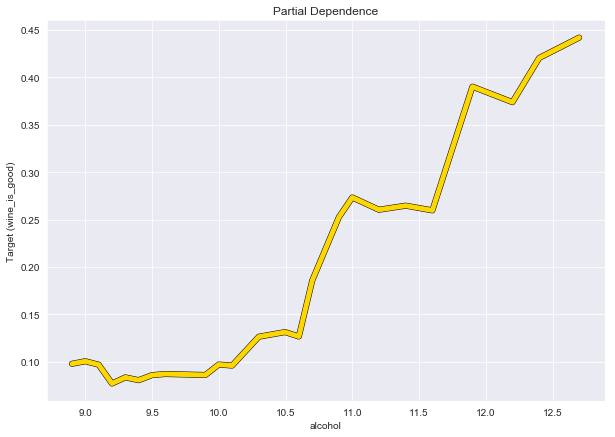

In [34]:
plot, plot_data = partial_dependence(project, best_model_reduced, validation, 'alcohol', ice_plot=False, std_dev_plot=False)

uploading augmented dataset with 25000 rows.
Requesting predictions on augmented dataset
Preparing plots


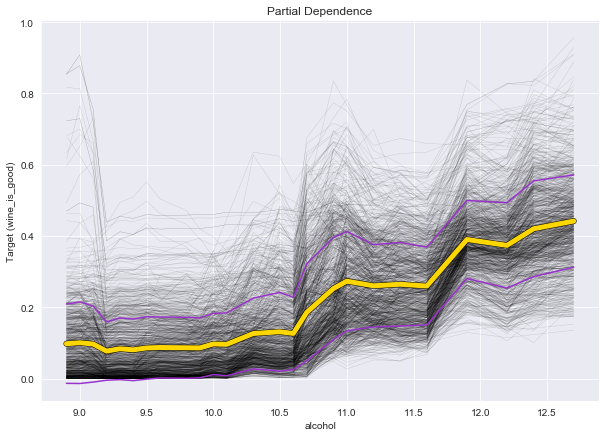

In [35]:
plot, plot_data = partial_dependence(project, best_model_reduced, validation, 'alcohol', ice_plot=True, std_dev_plot=True)